In [ ]:
from dataclasses import astuple
import os
from pathlib import Path 
import sys
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.mixture import GaussianMixture
import pickle
sys.path.insert(0, str(Path().absolute().parents[1]))

from experiments.datasets.faces import FaceImage, FaceAnnotation
from cv_prince.chap_07_complex_densities.gmm import ExpectationMaximisationGMM, GMMSampler

In [12]:
root_data_dir = os.environ.get("DATASETS")
data_dir = Path(root_data_dir) / "FDDB"
faces_dir = data_dir / "originalPics"
fold_dir = data_dir / "FDDB-folds"

num_folds = len(list(fold_dir.glob("*ellipseList.txt")))

In [13]:
test_fold = [10]
val_folds = [8, 9]
train_folds = [1, 2, 3, 4, 5, 6, 7]

In [ ]:
from collections import defaultdict
from dataclasses import dataclass
from enum import Enum


class FaceLabel(Enum):
    non_face: int = 0
    face: int = 1


@dataclass
class FaceDSParameters:
    seed:int =12345
    img_size: tuple[int, int] = (24, 24)
    non_face_max_overlap: float = 0.15
    non_face_min_proportion:float=0.85
    non_faces_num_instances:int=5
    non_faces_max_trials:int=100


class FaceDataset:
    """
    A class to handle face vs non-face images for detection.
    Follows the PyTorch Dataset class interface
    """

    def __init__(
            self, 
            annotation_dir: Path | str, 
            imgs_dir: Path | str, 
            params: FaceDSParameters = FaceDSParameters()
        ):

        self.annotations_dir = annotation_dir
        self.imgs_dir = imgs_dir
        self.params = params
        self.face_images: list[FaceImage] = []
        self.images_to_fold: np.ndarray | None = None
        self.faces_arr: np.ndarray | None = None
        self.non_faces_arr: np.ndarray | None = None
        self.image_to_face_data: dict[int, list[int]] = defaultdict(list)
        self.image_to_non_face_data: dict[int, list[int]] = defaultdict(list)
        self.rng = np.random.default_rng(seed=self.seed)

        self.__read_face_dataset_information()

    def __len__(self) -> int:
        if self.faces_arr is None:
            self.__load()
        
        return self.num_face_imgs + self.num_non_face_imgs
    
    def __getitem__(self, idx) -> tuple[np.ndarray, FaceLabel]:
        if idx < self.num_face_imgs:
            return self.faces_arr[idx, :], FaceLabel.face
        
        return self.faces_arr[idx-self.num_face_imgs, :], FaceLabel.non_face

    @property
    def num_face_imgs(self) -> int:
        if self.faces_arr is None:
            self.__load()

        return self.faces_arr.shape[0]
    
    @property
    def num_non_face_imgs(self) -> int:
        if self.non_faces_arr is None:
            self.__load()

        return self.non_faces_arr.shape[0]
    
    def transform_image(self, image: Image.Image) -> np.ndarray:
        image = image.convert("L")
        image = image.resize(self.img_size)
        image = np.asarray(image, dtype=np.float64)
        image = image.flatten()
        image /= 255.0
        return image

    def __read_face_dataset_information(self) -> list[FaceImage]:      
        images_to_fold = []  
        for fold_ellipse_file in sorted(self.annotations_dir.glob("FDDB-fold-*")):
            if not fold_ellipse_file.name.endswith("ellipseList.txt"):
                continue

            fold_id = int(fold_ellipse_file.name.split("-")[-2])

            with open(fold_ellipse_file, "r") as fid:
                while True:
                    line = fid.readline()
                    
                    if not line:
                        break

                    if line.endswith("\n"):
                        line = line[:-1]

                    assert line.startswith("2002") or line.startswith("2003")
                    
                    face_img_path = self.imgs_dir / (line + ".jpg")
                    num_faces = int(fid.readline())
                    faces = [
                        FaceAnnotation.from_str(fid.readline()) for _ in range(num_faces)
                    ]
                    face_image = FaceImage(
                        file_path=face_img_path, faces=faces
                    )

                    self.face_images.append(face_image)
                    images_to_fold.append(fold_id)

                self.images_to_fold = np.array(images_to_fold)
                        
    def __load(self):
        print("Loading Face Dataset")

        faces_arr = []
        non_faces_arr = []

        for img_id, face_image in enumerate(self.face_images):
            for face_id in range(face_image.num_faces):
                self.image_to_face_data[img_id].append(len(faces_arr))

                cropped_face = face_image.crop_face_img(face_id)
                faces_arr.append(self.transform_image(cropped_face))

            non_faces = face_image.crop_non_face_img(
                max_overlap=self.non_face_max_overlap, 
                min_allowed_size_proportion=self.non_face_min_proportion, 
                num_instances=self.non_faces_num_instances, 
                max_trials=self.non_faces_max_trials,
                rng=self.rng
            )
            
            for non_face in non_faces:
                self.image_to_non_face_data[img_id].append(len(non_faces_arr))
                non_faces_arr.append(self.transform_image(non_face))

        self.faces_arr = np.stack(faces_arr, axis=0)
        self.non_faces_arr = np.stack(non_faces_arr, axis=0)

        print("Face Dataset Loaded")


    @property
    def seed(self) -> int:
        return self.params.seed
    
    @property
    def img_size(self) -> tuple[int, int]:
        return self.params.img_size
    
    @property
    def non_face_max_overlap(self) -> float:
        return self.params.non_face_max_overlap
    
    @property
    def non_face_min_proportion(self) -> float:
        return self.params.non_face_min_proportion
    
    @property
    def non_faces_num_instances(self) -> int:
        return self.params.non_faces_num_instances
    
    @property
    def non_faces_max_trials(self) -> int:
        return self.params.non_faces_max_trials

In [15]:
face_dataset = FaceDataset(annotation_dir=fold_dir, imgs_dir=faces_dir)

In [16]:
print(len(face_dataset))
print(face_dataset.num_face_imgs)

Loading Face Dataset
Face Dataset Loaded
14734
5171


In [17]:
images_to_keep = np.isin(face_dataset.images_to_fold, train_folds)
images_to_keep = np.argwhere(images_to_keep).flatten()

faces_to_keep = np.concat([face_dataset.image_to_face_data[idx] for idx in images_to_keep])
non_faces_to_keep = np.concat(
    [
        face_dataset.image_to_non_face_data[idx] for idx in images_to_keep
        if len(face_dataset.image_to_non_face_data[idx]) > 0
    ]
)

In [18]:
num_samples = 1000
train_faces_arr = face_dataset.faces_arr[faces_to_keep, :]
train_non_faces_arr = face_dataset.non_faces_arr[non_faces_to_keep, :]

print(train_faces_arr.shape)
print(train_non_faces_arr.shape)

(3618, 576)
(6821, 576)


In [19]:
gmm = GaussianMixture(n_components=10, random_state=12345, init_params="random_from_data")
gmm._initialize_parameters(train_faces_arr, random_state=np.random.RandomState(gmm.random_state))
scipy_prediction = gmm.fit_predict(train_faces_arr)

In [20]:
# faces_em_fitter = ExpectationMaximisationGMM(num_components=10, seed=12345)
# faces_em_fitter.fit(train_faces_arr)

In [21]:
# non_faces_em_fitter = ExpectationMaximisationGMM(num_components=10, seed=12345)
# non_faces_em_fitter.fit(train_non_faces_arr)

In [22]:
# faces_gmm = faces_em_fitter.gmm
# non_faces_gmm = non_faces_em_fitter.gmm

# with open("faces_dist.pck", "wb") as fid:
#     pickle.dump(
#         {
#             "faces": faces_gmm,
#             "non_faces": non_faces_gmm
#         },
#         fid
#     )

In [ ]:
with open("faces_dist.pck", "rb") as fid:
    data = pickle.load(fid)

    faces_gmm: GMMSampler = data["faces"]
    non_faces_gmm: GMMSampler = data["non_faces"]

In [24]:
images_to_keep = np.isin(face_dataset.images_to_fold, val_folds)
images_to_keep = np.argwhere(images_to_keep).flatten()

faces_to_keep = np.concat([face_dataset.image_to_face_data[idx] for idx in images_to_keep])
non_faces_to_keep = np.concat(
    [
        face_dataset.image_to_non_face_data[idx] for idx in images_to_keep
        if len(face_dataset.image_to_non_face_data[idx]) > 0
    ]
)

val_faces_arr = face_dataset.faces_arr[faces_to_keep, :]
val_non_faces_arr = face_dataset.non_faces_arr[non_faces_to_keep, :]

In [25]:
gmm.score_samples(val_faces_arr)

array([925.75889382, 790.96652683, 491.18783538, ..., 345.65630907,
       832.0034116 , 507.76296883], shape=(1032,))

In [26]:
faces_log_likelihood = faces_gmm.log_pdf(val_faces_arr)
non_faces_log_likelihood = non_faces_gmm.log_pdf(val_faces_arr)

max_likelihood = np.maximum(faces_log_likelihood, non_faces_log_likelihood)
lse = max_likelihood + np.log(
    np.exp(faces_log_likelihood-max_likelihood) 
    + np.exp(non_faces_log_likelihood-max_likelihood)
)


faces_proba = np.exp(faces_log_likelihood - lse)
non_faces_proba = np.exp(non_faces_log_likelihood - lse)

(non_faces_proba > 0.5).sum() / val_faces_arr.shape[0]

np.float64(0.11724806201550388)

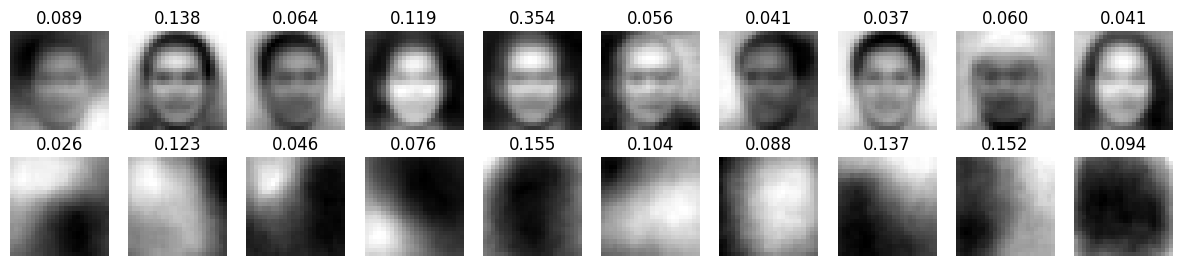

In [28]:
fig, axes = plt.subplots(2, 10, figsize=(15, 3))

for i in range(10):
    axes[0, i].imshow(faces_gmm.gaussians[i].mean.reshape((24, 24)), cmap="gray")
    axes[1, i].imshow(non_faces_gmm.gaussians[i].mean.reshape((24, 24)), cmap="gray")

    axes[0,i].set_title(f"{faces_gmm.weights[i]:.3f}")
    axes[0,i].set_axis_off()
    axes[1,i].set_title(f"{non_faces_gmm.weights[i]:.3f}")
    axes[1,i].set_axis_off()

In [ ]:
img_with_most_faces = face_dataset.face_images[0]
for face_image in face_dataset.face_images[1:]:
    if face_image.num_faces > img_with_most_faces.num_faces:
        img_with_most_faces = face_image

k = 5
img_with_k_faces = None
for face_image in face_dataset.face_images:
    if face_image.num_faces == k:
        img_with_k_faces = face_image
        break

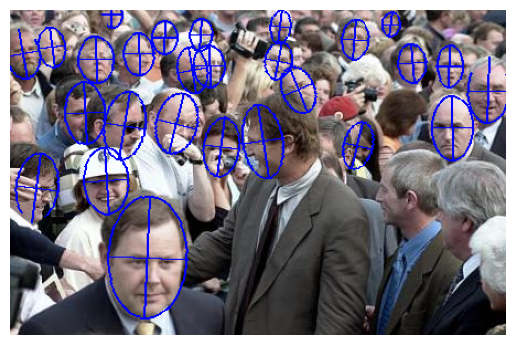

In [ ]:
face_image = img_with_most_faces
img = face_image.show_annotated_image()

plt.imshow(img)
plt.gca().set_axis_off()

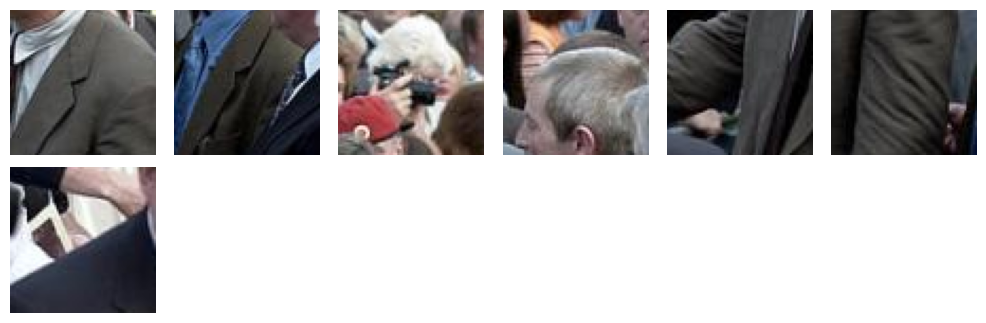

In [ ]:
num_instances = None
res = face_image.crop_non_face_img(
    seed=12345, max_overlap=0.1, num_instances=num_instances
)

num_cols = 6
num_rows = int(np.ceil(len(res) / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 10 / num_cols))

for ax, non_face_img in zip(axes.flatten(), res):
    ax.imshow(non_face_img)
    ax.set_axis_off()

num_img_in_last_row = len(res) % num_cols
if num_img_in_last_row > 0:
    for i in range(num_cols-num_img_in_last_row):
        fig.delaxes(axes.flat[-i-1])

fig.tight_layout()

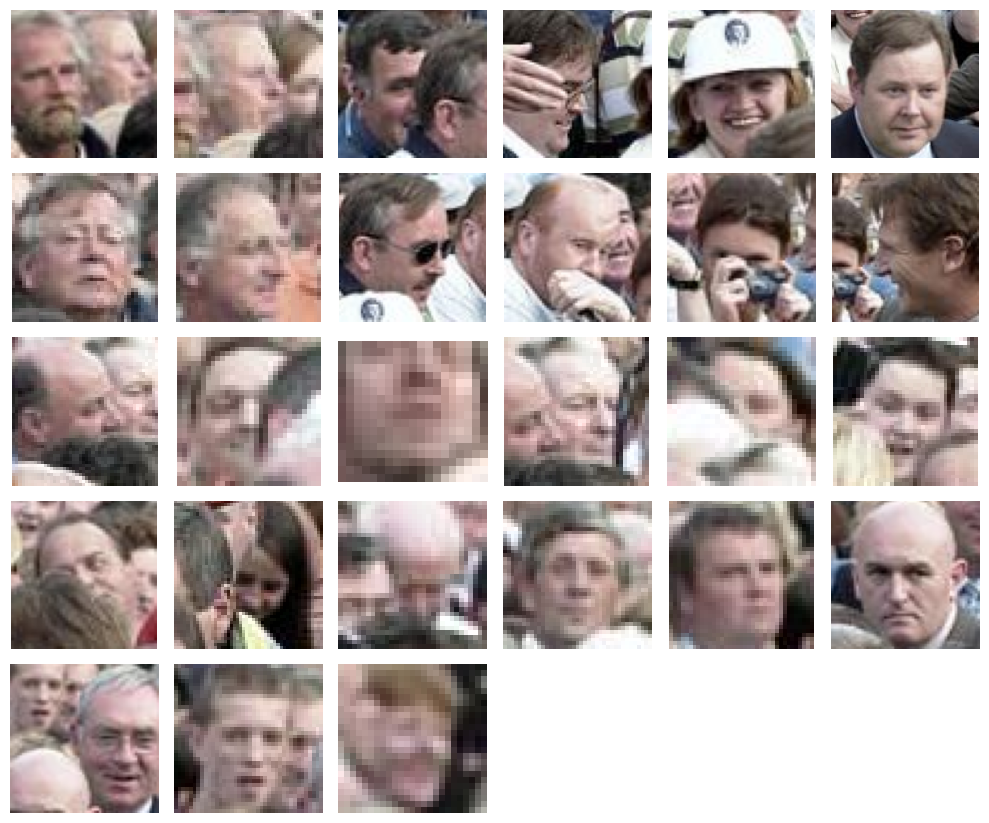

In [ ]:
num_faces = face_image.num_faces

num_rows = int(np.ceil(num_faces / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 10 / num_cols))

for ax, cropped_face in zip(axes.flatten(), face_image.get_all_croped_faces()):
    ax.imshow(cropped_face, cmap="gray")
    ax.set_aspect("equal")
    ax.set_axis_off()

num_img_in_last_row = num_faces % num_cols
if num_img_in_last_row > 0:
    for i in range(num_cols-num_img_in_last_row):
        fig.delaxes(axes.flat[-i-1])

fig.tight_layout()